In [42]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


print(torch.__version__)

1.12.0+cu102


In [43]:
sampled_z = np.random.choice([0, 1], size=1024)
data = ((sampled_z + 1) % 2) * np.random.normal(
    size=sampled_z.shape, loc=-1, scale=0.5
) + sampled_z * np.random.normal(size=sampled_z.shape, loc=1, scale=0.25)
nbins = 32
_, bins = np.histogram(data, bins=nbins)
class_data = np.apply_along_axis(
    lambda x: np.histogram(x, bins)[0], 1, data.reshape(-1, 1)
)
nclasses = nbins

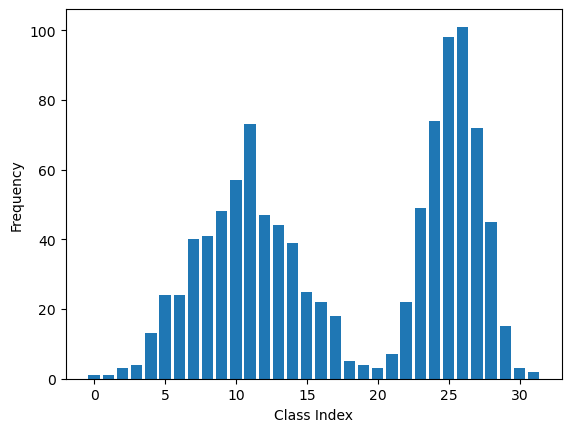

In [44]:
plt.bar(np.arange(nclasses), height=np.sum(class_data, axis=0))
plt.xlabel("Class Index")
plt.ylabel("Frequency")
plt.show()

In [45]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 32

x_dim = 32 
hidden_dim = 16
latent_dim = 1

lr = 1e-3

epochs = 16

In [46]:
import torch
import torch.nn as nn


cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True
    
    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        
        z = mean + var*epsilon                          
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5*log_var)) 
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var


In [47]:
# from model import Encoder, Decoder, Model


encoder = Encoder(x_dim, hidden_dim, latent_dim).to(DEVICE)
decoder = Decoder(latent_dim, hidden_dim, x_dim).to(DEVICE)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [48]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 获取给定索引的数据点，并将其转换为PyTorch张量
        sample = torch.Tensor(self.data[idx])
        return sample


kwargs = {'num_workers': 1, 'pin_memory': True} 

dataset = CustomDataset(class_data)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, **kwargs)

# total_size = len(class_data)
# indices = list(range(total_size))
# train_size = int(0.8 * total_size)
# test_size = total_size - train_size
# train_sampler = SubsetRandomSampler(indices[:train_size])
# test_sampler = SubsetRandomSampler(indices[-test_size:])

# train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, **kwargs)
# test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, **kwargs)

In [49]:
from torch.optim import Adam


BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

In [50]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(tqdm(train_loader)):
        # x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, x_mean, x_log_var = model(x)
        loss = loss_function(x, x_hat, x_mean, x_log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch+1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


100%|██████████| 32/32 [00:00<00:00, 108.81it/s]


	Epoch 1 complete! 	Average Loss:  21.783103389124715


100%|██████████| 32/32 [00:00<00:00, 121.94it/s]


	Epoch 2 complete! 	Average Loss:  18.80846946470199


100%|██████████| 32/32 [00:00<00:00, 131.05it/s]


	Epoch 3 complete! 	Average Loss:  14.009215231864683


100%|██████████| 32/32 [00:00<00:00, 116.99it/s]


	Epoch 4 complete! 	Average Loss:  8.965210130137782


100%|██████████| 32/32 [00:00<00:00, 111.05it/s]


	Epoch 5 complete! 	Average Loss:  6.830134745567076


100%|██████████| 32/32 [00:00<00:00, 121.08it/s]


	Epoch 6 complete! 	Average Loss:  5.852751516526745


100%|██████████| 32/32 [00:00<00:00, 92.57it/s]


	Epoch 7 complete! 	Average Loss:  5.398569522365447


100%|██████████| 32/32 [00:00<00:00, 92.32it/s] 


	Epoch 8 complete! 	Average Loss:  5.03450398291311


100%|██████████| 32/32 [00:00<00:00, 114.55it/s]


	Epoch 9 complete! 	Average Loss:  4.656714485537622


100%|██████████| 32/32 [00:00<00:00, 131.85it/s]


	Epoch 10 complete! 	Average Loss:  4.38982299066359


100%|██████████| 32/32 [00:00<00:00, 121.21it/s]


	Epoch 11 complete! 	Average Loss:  4.31526570166311


100%|██████████| 32/32 [00:00<00:00, 140.53it/s]


	Epoch 12 complete! 	Average Loss:  4.278007561160672


100%|██████████| 32/32 [00:00<00:00, 125.31it/s]


	Epoch 13 complete! 	Average Loss:  4.269123792648315


100%|██████████| 32/32 [00:00<00:00, 143.49it/s]


	Epoch 14 complete! 	Average Loss:  4.248991197155368


100%|██████████| 32/32 [00:00<00:00, 149.08it/s]


	Epoch 15 complete! 	Average Loss:  4.239041982158538


100%|██████████| 32/32 [00:00<00:00, 123.65it/s]

	Epoch 16 complete! 	Average Loss:  4.228723302964242
Finish!!


In [51]:
zs = torch.randn(size=(1024, 1)).to(DEVICE)
sampled_x = model.Decoder(zs)
sampled_x = sampled_x.cpu().detach().numpy()

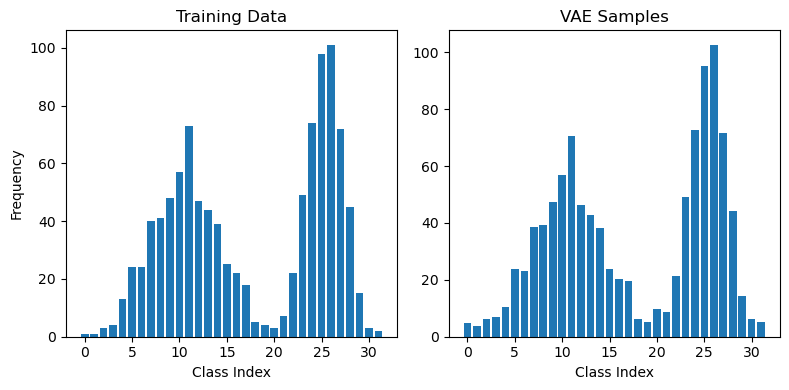

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
axs[0].set_title("Training Data")
axs[0].bar(np.arange(nbins), height=np.sum(class_data, axis=0))
axs[0].set_xlabel("Class Index")
axs[0].set_ylabel("Frequency")
axs[1].set_title("VAE Samples")
axs[1].bar(np.arange(nbins), height=np.sum(sampled_x, axis=0))
axs[1].set_xlabel("Class Index")
plt.tight_layout()
plt.show()